# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [240]:
# Import warnings



In [241]:
# Import the libraries you will be using for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import os



In [242]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 2.0.1
pandas version: 2.2.3
matplotlib version: 3.10.0
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [243]:
# Try loading one file

# df = pd.read_parquet('2023-1.parquet')
# df.info()

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [244]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [245]:
# from google.colab import drive
# drive.mount('/content/drive')

In [246]:
# Select the folder having data files
os.chdir('/Users/subhasishbiswas/GIT/Interstellar/UpGrad/Code/Courses/C1-SQL and Statistics Essentials/M7-NYC Taxi Records Analysis/SUBHASISH BISWAS/EDA NYC Taxi/Datasets and Dictionary/trip_records')
# Create a list of all the twelve files to read

# initialise an empty dataframe
df = pd.DataFrame()

file_list = os.listdir()
print(file_list)




['2023-12.parquet', '2023-6.parquet', '2023-7.parquet', '.DS_Store', '2023-5.parquet', '2023-11.parquet', '2023-10.parquet', '2023-4.parquet', '2023-1.parquet', '2023-8.parquet', '2023-9.parquet', '2023-2.parquet', '2023-3.parquet']


In [247]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data




# iterate through the list of files and sample one by one:
for file_name in file_list:
    try:
        # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)
        print(f"Reading file: {file_name}")
        # Reading the current file

        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.
        sampled_data = pd.DataFrame()
        df_month = pd.read_parquet(file_path)
        df_month['date'] = df_month['tpep_pickup_datetime'].dt.date
        df_month['hour'] = df_month['tpep_pickup_datetime'].dt.hour

        # Loop through dates and then loop through every hour of each date
        # Sample 5% of the hourly data randomly
        # add data of this hour to the dataframe
        for date in df_month['date'].unique():
            for hour in range(24):
                # Filter data for the current date and hour
                hour_data = df_month[(df_month['date'] == date) & (df_month['hour'] == hour)]
                # Sample 5% of the hourly data randomly
                if len(hour_data) > 0:
                    sample = hour_data.sample(frac=0.05, random_state=42)
                    sampled_data = pd.concat([sampled_data, sample])

        # Concatenate the sampled data of all the dates to a single dataframe
        df = pd.concat([df, sampled_data])

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

# Store the df in csv/parquet
df.to_parquet('Sampled_NYC_Taxi_Data.parquet')
df


Reading file: 2023-12.parquet
Reading file: 2023-6.parquet
Reading file: 2023-7.parquet
Reading file: .DS_Store
Error reading file .DS_Store: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.
Reading file: 2023-5.parquet
Reading file: 2023-11.parquet
Reading file: 2023-10.parquet
Reading file: 2023-4.parquet
Reading file: 2023-1.parquet
Reading file: 2023-8.parquet
Reading file: 2023-9.parquet
Reading file: 2023-2.parquet
Reading file: 2023-3.parquet


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,date,hour,airport_fee
1788,2,2023-12-01 00:27:51,2023-12-01 00:50:12,1.0,3.99,1.0,N,148,50,1,...,0.5,5.66,0.0,1.0,33.96,2.5,0.0,2023-12-01,0,NaN
3196699,2,2023-12-01 00:38:48,2023-12-01 01:01:55,NaN,4.79,NaN,None,231,61,0,...,0.5,3.00,0.0,1.0,29.43,NaN,NaN,2023-12-01,0,NaN
1408,2,2023-12-01 00:06:19,2023-12-01 00:16:57,1.0,1.05,1.0,N,161,161,1,...,0.5,3.14,0.0,1.0,18.84,2.5,0.0,2023-12-01,0,NaN
3196663,2,2023-12-01 00:00:50,2023-12-01 00:14:37,NaN,2.08,NaN,None,137,144,0,...,0.5,0.00,0.0,1.0,21.22,NaN,NaN,2023-12-01,0,NaN
3613,2,2023-12-01 00:16:07,2023-12-01 00:19:17,1.0,0.40,1.0,N,68,68,1,...,0.5,0.00,0.0,1.0,10.10,2.5,0.0,2023-12-01,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3203004,2,2023-06-30 23:53:10,2023-07-01 00:05:55,1.0,2.63,1.0,N,170,143,1,...,0.5,4.80,0.0,1.0,24.00,2.5,0.0,2023-06-30,23,NaN
3203122,1,2023-06-30 23:22:42,2023-06-30 23:39:06,1.0,0.00,99.0,N,90,232,1,...,0.5,0.00,0.0,1.0,19.70,0.0,0.0,2023-06-30,23,NaN
3206515,1,2023-06-30 23:50:42,2023-07-01 00:20:00,2.0,5.40,1.0,N,87,161,1,...,0.5,2.00,0.0,1.0,39.40,2.5,0.0,2023-06-30,23,NaN
3206491,1,2023-06-30 23:05:31,2023-06-30 23:15:52,1.0,1.00,1.0,N,87,231,2,...,0.5,0.00,0.0,1.0,15.70,2.5,0.0,2023-06-30,23,NaN


After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [248]:
# Load the new data file

try:
    df = pd.read_parquet('Sampled_NYC_Taxi_Data.parquet')
except FileNotFoundError:
    print("Error: 'Sampled_NYC_Taxi_Data.parquet' DataFrame not found or saved file not found. Please make sure you have sampled and saved the data first.")
print(df.count().sum())

39500030


In [249]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,date,hour,airport_fee
1788,2,2023-12-01 00:27:51,2023-12-01 00:50:12,1.0,3.99,1.0,N,148,50,1,...,0.5,5.66,0.0,1.0,33.96,2.5,0.0,2023-12-01,0,NaN
3196699,2,2023-12-01 00:38:48,2023-12-01 01:01:55,NaN,4.79,NaN,None,231,61,0,...,0.5,3.00,0.0,1.0,29.43,NaN,NaN,2023-12-01,0,NaN
1408,2,2023-12-01 00:06:19,2023-12-01 00:16:57,1.0,1.05,1.0,N,161,161,1,...,0.5,3.14,0.0,1.0,18.84,2.5,0.0,2023-12-01,0,NaN
3196663,2,2023-12-01 00:00:50,2023-12-01 00:14:37,NaN,2.08,NaN,None,137,144,0,...,0.5,0.00,0.0,1.0,21.22,NaN,NaN,2023-12-01,0,NaN
3613,2,2023-12-01 00:16:07,2023-12-01 00:19:17,1.0,0.40,1.0,N,68,68,1,...,0.5,0.00,0.0,1.0,10.10,2.5,0.0,2023-12-01,0,NaN


In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1896400 entries, 1788 to 3202916
Data columns (total 22 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee            f

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [251]:
# Reset the index
df = df.reset_index(drop=True)

'''
I'm dropping the columns VendorID, store_and_fwd_flag, payment_ type,
tpep_pickup_datetime, and tpep_dropoff _datetime because they are not directly relevant to
the analysis and can be dropped. The goal of the analysis is to uncover insights that could help
optimize taxi operations, and these columns do not provide any direct information about taxi
operations. For example, the Vendor ID column indicates the provider that provided the record,
which is not relevant to the analysis. Similarly, the store_and_fwd_flag column indicates
whether the trip record was held in vehicle memory before sending to the vendor, which is also
not relevant to the analvsis.
'''
# Drop unnecessary columns
df = df.drop(columns=['VendorID', 'store_and_fwd_flag'])

df.describe()


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,hour,airport_fee
count,1896400,1896400,1.831526e+06,1.896400e+06,1.831526e+06,1.896400e+06,1.896400e+06,1.896400e+06,1.896400e+06,1.896400e+06,1.896400e+06,1.896400e+06,1.896400e+06,1.896400e+06,1.896400e+06,1.831526e+06,1.683043e+06,1.896400e+06,148483.000000
mean,2023-07-02 19:59:52.930795,2023-07-02 20:17:18.919564,1.369215e+00,3.858293e+00,1.634694e+00,1.652814e+02,1.640515e+02,1.163817e+00,1.991935e+01,1.588018e+00,4.952796e-01,3.547011e+00,5.965338e-01,9.989706e-01,2.898186e+01,2.307524e+00,1.458850e-01,1.426504e+01,0.109036
min,2022-12-31 23:51:30,2022-12-31 23:56:06,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-2.500000e+00,-5.000000e-01,0.000000e+00,0.000000e+00,-1.000000e+00,-5.750000e+00,-2.500000e+00,-1.750000e+00,0.000000e+00,-1.250000
25%,2023-04-02 16:10:08.750000,2023-04-02 16:27:43.500000,1.000000e+00,1.050000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,9.300000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.596000e+01,2.500000e+00,0.000000e+00,1.100000e+01,0.000000
50%,2023-06-27 15:44:22.500000,2023-06-27 16:01:15,1.000000e+00,1.790000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.350000e+01,1.000000e+00,5.000000e-01,2.850000e+00,0.000000e+00,1.000000e+00,2.100000e+01,2.500000e+00,0.000000e+00,1.500000e+01,0.000000
75%,2023-10-06 19:37:45,2023-10-06 19:53:39,1.000000e+00,3.400000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.190000e+01,2.500000e+00,5.000000e-01,4.420000e+00,0.000000e+00,1.000000e+00,3.094000e+01,2.500000e+00,0.000000e+00,1.900000e+01,0.000000
max,2023-12-31 23:57:51,2024-01-01 20:50:55,9.000000e+00,1.263605e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,1.431635e+05,2.080000e+01,4.000000e+00,2.230800e+02,1.430000e+02,1.000000e+00,1.431675e+05,2.500000e+00,1.750000e+00,2.300000e+01,1.250000
std,NaN,NaN,8.927560e-01,1.294085e+02,7.393915e+00,6.400038e+01,6.980207e+01,5.081384e-01,1.055371e+02,1.829200e+00,4.885128e-02,4.054882e+00,2.187878e+00,3.112072e-02,1.064162e+02,6.667267e-01,4.733757e-01,5.807381e+00,0.352744


  **2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [252]:
# Combine the two airport fee columns

print(df[['airport_fee', 'Airport_fee']].head())
# Rename the columns
df.rename(columns={'airport_fee': 'airport_fee1', 'Airport_fee': 'airport_fee2'}, inplace=True)

# Fill null values with 0
df['airport_fee1'] = df['airport_fee1'].fillna(0)
df['airport_fee2'] = df['airport_fee2'].fillna(0)

# Combine the two columns
df['airport_fee'] = df['airport_fee1'] + df['airport_fee2']

# Drop the original columns
df = df.drop(columns=['airport_fee1', 'airport_fee2'])

# Save the updated DataFrame
df.to_csv('1_Cleaned_Sampled_NYC_Taxi_Data.csv', index=False)

   airport_fee  Airport_fee
0          NaN          0.0
1          NaN          NaN
2          NaN          0.0
3          NaN          NaN
4          NaN          0.0


**2.1.4** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [253]:
# check where values of fare amount are negative
# Filter the DataFrame to show only rows where `fare_amount` is negative
#negative_fare_amount = df[df['fare_amount'] < 0]
#num_negative_fares = len(negative_fare_amount)  # Get the count of rows
#print(f"Number of negative fare_amount values: {num_negative_fares}")

# 2. Remove negative values from specified columns
columns_to_check = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']

for col in columns_to_check:
    # Count negative values before removal
    num_negatives_before = (df[col] < 0).sum()

    # Remove negative values
    df = df[df[col] >= 0]

    # Count negative values after removal (should be 0)
    num_negatives_after = (df[col] < 0).sum()

    print(f"\nColumn '{col}':")
    print(f"  - Number of negative values before removal: {num_negatives_before}")
    print(f"  - Number of negative values after removal: {num_negatives_after}")

df.to_csv("2_Cleaned_Sampled_NYC_Taxi_Data.csv", index=False)
print("Cleaned data saved to '2_Cleaned_Sampled_NYC_Taxi_Data.csv'")


Column 'fare_amount':
  - Number of negative values before removal: 0
  - Number of negative values after removal: 0

Column 'tip_amount':
  - Number of negative values before removal: 0
  - Number of negative values after removal: 0

Column 'total_amount':
  - Number of negative values before removal: 78
  - Number of negative values after removal: 0

Column 'trip_distance':
  - Number of negative values before removal: 0
  - Number of negative values after removal: 0
Cleaned data saved to '2_Cleaned_Sampled_NYC_Taxi_Data.csv'


In [254]:
# Analyse the above parameters
columns_to_check = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']

for col in columns_to_check:
    num_zeros = (df[col] == 0).sum()
    num_negatives = (df[col] < 0).sum()
    print(f"\nColumn '{col}':")
    print(f"  - Number of zero values: {num_zeros}")
    print(f"  - Number of negative values: {num_negatives}")


Column 'fare_amount':
  - Number of zero values: 573
  - Number of negative values: 0

Column 'tip_amount':
  - Number of zero values: 435880
  - Number of negative values: 0

Column 'total_amount':
  - Number of zero values: 310
  - Number of negative values: 0

Column 'trip_distance':
  - Number of zero values: 37712
  - Number of negative values: 0


Did you notice something different in the `RatecodeID` column for above records?

In [255]:
# Analyse RatecodeID for the negative fare amounts
'''
Looking at the data dictionary, the RateCodeID column has values ranging from 1 to 6,
with each number representing a specific rate type.

However, in the records where fare_amount
is negative, there are instances of RateCodeID being 99, which is not a defined code in the data
dictionary.

This discrepancy suggests that there might be errors or inconsistencies in the data, specifically
related to the RateCodeID column. It's possible that the code 99 was used to represent a special
type of fare or that it was an error during data entry.
'''

try:
    df = pd.read_csv('2_Cleaned_Sampled_NYC_Taxi_Data.csv')
except FileNotFoundError:
    print("Error: 'Sampled_NYC_Taxi_Data.parquet' DataFrame not found or saved file not found. Please make sure you have sampled and saved the data first.")
print(df.count().sum())

# Count the frequency of each unique value in `RateCodeID`
ratecode_counts = df['RatecodeID'].value_counts()
# Display the counts
print(ratecode_counts.to_markdown(numalign="left", stralign="left"))

# Display rows with negative `fare_amount` and `RateCodeID` other than 99
other_ratecodes = df[df['RatecodeID']!= 99]
other_ratecodes.head()

35835496
| RatecodeID   | count       |
|:-------------|:------------|
| 1            | 1.72921e+06 |
| 2            | 71646       |
| 99           | 10472       |
| 5            | 10272       |
| 3            | 6123        |
| 4            | 3722        |
| 6            | 3           |


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,date,hour,airport_fee
0,2023-12-01 00:27:51,2023-12-01 00:50:12,1.0,3.99,1.0,148,50,1,23.30,1.0,0.5,5.66,0.0,1.0,33.96,2.5,2023-12-01,0,0.0
1,2023-12-01 00:38:48,2023-12-01 01:01:55,NaN,4.79,NaN,231,61,0,22.43,0.0,0.5,3.00,0.0,1.0,29.43,NaN,2023-12-01,0,0.0
2,2023-12-01 00:06:19,2023-12-01 00:16:57,1.0,1.05,1.0,161,161,1,10.70,1.0,0.5,3.14,0.0,1.0,18.84,2.5,2023-12-01,0,0.0
3,2023-12-01 00:00:50,2023-12-01 00:14:37,NaN,2.08,NaN,137,144,0,17.22,0.0,0.5,0.00,0.0,1.0,21.22,NaN,2023-12-01,0,0.0
4,2023-12-01 00:16:07,2023-12-01 00:19:17,1.0,0.40,1.0,68,68,1,5.10,1.0,0.5,0.00,0.0,1.0,10.10,2.5,2023-12-01,0,0.0


In [256]:
# Find which columns have negative values
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        if (df[col] < 0).any():
            print(f"Column '{col}' has {len(df[df[col] < 0])} negative values")


Column 'extra' has 1 negative values


In [257]:
# fix these negative values

# Convert negative values to positive values
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col].abs()

# Save the updated DataFrame
df.to_csv('2_Cleaned_Sampled_NYC_Taxi_Data.csv', index=False)

In [258]:
try:
   df=pd.read_csv('2_Cleaned_Sampled_NYC_Taxi_Data.csv')
except FileNotFoundError:
    print("Error: DataFrame not found or saved file not found. Please make sure you have sampled and saved the data first.")

### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [259]:
# Find the proportion of missing values in each column
missing_prop = df.isnull().mean()
missing_prop

tpep_pickup_datetime     0.00000
tpep_dropoff_datetime    0.00000
passenger_count          0.03421
trip_distance            0.00000
RatecodeID               0.03421
PULocationID             0.00000
DOLocationID             0.00000
payment_type             0.00000
fare_amount              0.00000
extra                    0.00000
mta_tax                  0.00000
tip_amount               0.00000
tolls_amount             0.00000
improvement_surcharge    0.00000
total_amount             0.00000
congestion_surcharge     0.03421
date                     0.00000
hour                     0.00000
airport_fee              0.00000
dtype: float64

**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [260]:
# Display the rows with null values
null_rows = df[df.isnull().any(axis=1)]
null_rows

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,date,hour,airport_fee
1,2023-12-01 00:38:48,2023-12-01 01:01:55,NaN,4.79,NaN,231,61,0,22.43,0.00,0.5,3.00,0.00,1.0,29.43,NaN,2023-12-01,0,0.0
3,2023-12-01 00:00:50,2023-12-01 00:14:37,NaN,2.08,NaN,137,144,0,17.22,0.00,0.5,0.00,0.00,1.0,21.22,NaN,2023-12-01,0,0.0
27,2023-12-01 00:01:11,2023-12-01 00:15:53,NaN,3.49,NaN,164,262,0,17.83,0.00,0.5,0.00,0.00,1.0,21.83,NaN,2023-12-01,0,0.0
122,2023-12-01 00:02:18,2023-12-01 00:12:25,NaN,1.79,NaN,142,239,0,9.88,0.00,0.5,0.00,0.00,1.0,13.88,NaN,2023-12-01,0,0.0
127,2023-12-01 00:04:14,2023-12-01 00:25:16,NaN,0.00,NaN,186,74,0,30.31,0.00,0.5,0.00,0.00,1.0,34.31,NaN,2023-12-01,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896215,2023-06-30 23:14:07,2023-06-30 23:25:45,NaN,0.70,NaN,230,186,0,11.40,1.00,0.5,2.46,0.00,1.0,18.86,NaN,2023-06-30,23,0.0
1896231,2023-06-30 23:40:46,2023-07-01 00:04:37,NaN,4.46,NaN,143,79,0,23.26,0.00,0.5,0.00,0.00,1.0,27.26,NaN,2023-06-30,23,0.0
1896274,2023-06-30 23:57:33,2023-07-01 00:09:15,NaN,2.75,NaN,166,142,0,16.14,0.00,0.5,0.00,0.00,1.0,20.14,NaN,2023-06-30,23,0.0
1896295,2023-06-30 23:36:40,2023-06-30 23:53:20,NaN,5.18,NaN,148,237,0,26.09,0.00,0.5,3.01,0.00,1.0,33.10,NaN,2023-06-30,23,0.0


In [261]:
# Impute NaN values in 'passenger_count'
# Impute NaN values in `passenger_count` with the mean
print("Before removing passenger_count: " + str(df['passenger_count'].isnull().sum()))
df['passenger_count'] = df['passenger_count'].fillna(df['passenger_count'].mean())
print("After removing passenger_count: " + str(df['passenger_count'].isnull().sum()))


Before removing passenger_count: 64874
After removing passenger_count: 0


In [262]:
# Display the rows with missing values
df[df.isnull().any(axis=1)].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,date,hour,airport_fee
1,2023-12-01 00:38:48,2023-12-01 01:01:55,1.369209,4.79,NaN,231,61,0,22.43,0.0,0.5,3.0,0.0,1.0,29.43,NaN,2023-12-01,0,0.0
3,2023-12-01 00:00:50,2023-12-01 00:14:37,1.369209,2.08,NaN,137,144,0,17.22,0.0,0.5,0.0,0.0,1.0,21.22,NaN,2023-12-01,0,0.0
27,2023-12-01 00:01:11,2023-12-01 00:15:53,1.369209,3.49,NaN,164,262,0,17.83,0.0,0.5,0.0,0.0,1.0,21.83,NaN,2023-12-01,0,0.0
122,2023-12-01 00:02:18,2023-12-01 00:12:25,1.369209,1.79,NaN,142,239,0,9.88,0.0,0.5,0.0,0.0,1.0,13.88,NaN,2023-12-01,0,0.0
127,2023-12-01 00:04:14,2023-12-01 00:25:16,1.369209,0.00,NaN,186,74,0,30.31,0.0,0.5,0.0,0.0,1.0,34.31,NaN,2023-12-01,0,0.0


Did you find zeroes in passenger_count? Handle these.

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [263]:
# Fix missing values in 'RatecodeID'


# Impute missing values in `RateCodeID` with the mean

# Display the count of missing values in `RatecodeID`
print("Before removing RatecodeID: " + str(df['RatecodeID'].isnull().sum()))

# Impute the missing values in `RatecodeID` with its mean
df['RatecodeID'] = df['RatecodeID'].fillna(df['RatecodeID'].mean())

# Verify the count of missing values in `RatecodeID` after imputation
print("Before removing RatecodeID: " + str(df['RatecodeID'].isnull().sum()))


df.to_csv('3_Cleaned_Sampled_NYC_Taxi_Data.csv', index=False)



Before removing RatecodeID: 64874
Before removing RatecodeID: 0


In [264]:
try:
   df=pd.read_csv('3_Cleaned_Sampled_NYC_Taxi_Data.csv')
except FileNotFoundError:
    print("Error: DataFrame not found or saved file not found. Please make sure you have sampled and saved the data first.")
df

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,date,hour,airport_fee
0,2023-12-01 00:27:51,2023-12-01 00:50:12,1.000000,3.99,1.000000,148,50,1,23.30,1.0,0.5,5.66,0.0,1.0,33.96,2.5,2023-12-01,0,0.0
1,2023-12-01 00:38:48,2023-12-01 01:01:55,1.369209,4.79,1.634698,231,61,0,22.43,0.0,0.5,3.00,0.0,1.0,29.43,NaN,2023-12-01,0,0.0
2,2023-12-01 00:06:19,2023-12-01 00:16:57,1.000000,1.05,1.000000,161,161,1,10.70,1.0,0.5,3.14,0.0,1.0,18.84,2.5,2023-12-01,0,0.0
3,2023-12-01 00:00:50,2023-12-01 00:14:37,1.369209,2.08,1.634698,137,144,0,17.22,0.0,0.5,0.00,0.0,1.0,21.22,NaN,2023-12-01,0,0.0
4,2023-12-01 00:16:07,2023-12-01 00:19:17,1.000000,0.40,1.000000,68,68,1,5.10,1.0,0.5,0.00,0.0,1.0,10.10,2.5,2023-12-01,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896317,2023-06-30 23:53:10,2023-07-01 00:05:55,1.000000,2.63,1.000000,170,143,1,14.20,1.0,0.5,4.80,0.0,1.0,24.00,2.5,2023-06-30,23,0.0
1896318,2023-06-30 23:22:42,2023-06-30 23:39:06,1.000000,0.00,99.000000,90,232,1,18.20,0.0,0.5,0.00,0.0,1.0,19.70,0.0,2023-06-30,23,0.0
1896319,2023-06-30 23:50:42,2023-07-01 00:20:00,2.000000,5.40,1.000000,87,161,1,32.40,3.5,0.5,2.00,0.0,1.0,39.40,2.5,2023-06-30,23,0.0
1896320,2023-06-30 23:05:31,2023-06-30 23:15:52,1.000000,1.00,1.000000,87,231,2,10.70,3.5,0.5,0.00,0.0,1.0,15.70,2.5,2023-06-30,23,0.0


**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [265]:
# handle null values in congestion_surcharge

# Display the rows with missing values
df[df.isnull().any(axis=1)].head()
print("Before removing congestion_surcharge: " + str(df['congestion_surcharge'].isnull().sum()))
# Impute missing values in `congestion_surcharge` with the mode
df['congestion_surcharge'] = df['congestion_surcharge'].fillna(df['congestion_surcharge'].mean())
df.to_csv('3_Cleaned_Sampled_NYC_Taxi_Data.csv', index=False)
print("After removing congestion_surcharge: " + str(df['congestion_surcharge'].isnull().sum()))

Before removing congestion_surcharge: 64874
After removing congestion_surcharge: 0


Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [266]:
# Handle any remaining missing values

'''
    Since there is no missing values in the dataset, there is no need to handle any remaining missing values.
'''
df[df.isnull().any(axis=1)].head()


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,date,hour,airport_fee


### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

In [267]:
print('''

• High Fare, Near-Zero Distance: This could indicate errors in recording the distance or
special circumstances like waiting time.

• Zero Distance and Fare with Different Zones: This is likely an error, as trips between
different zones should always have some distance and fare.

• Extremely Long Trips: While possible, trips over 250 miles within NYC are unusual and might
warrant further investigation.

• Invalid Payment Type: Payment type O is undefined, so these records need correction or
removal.

''')



• High Fare, Near-Zero Distance: This could indicate errors in recording the distance or
special circumstances like waiting time.

• Zero Distance and Fare with Different Zones: This is likely an error, as trips between
different zones should always have some distance and fare.

• Extremely Long Trips: While possible, trips over 250 miles within NYC are unusual and might
warrant further investigation.

• Invalid Payment Type: Payment type O is undefined, so these records need correction or
removal.




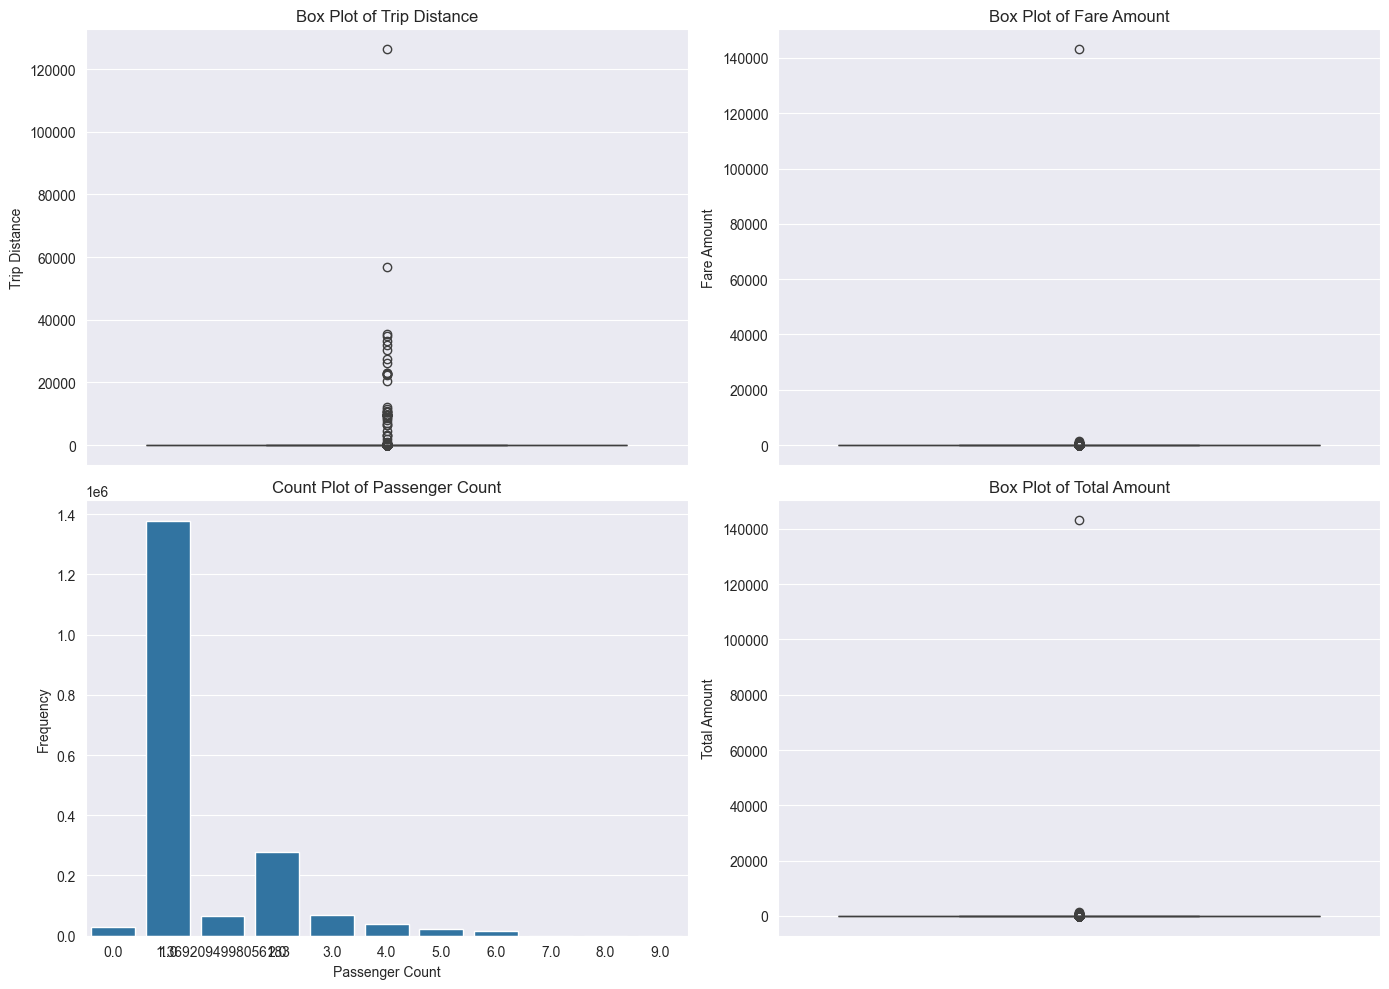

In [268]:
import matplotlib.pyplot as plt
import seaborn as sns

#... (your data loading and cleaning code)...

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns

# a. Trip Distance (top-left)
sns.boxplot(y=df['trip_distance'], ax=axes[0, 0])
axes[0, 0].set_title('Box Plot of Trip Distance')
axes[0, 0].set_ylabel('Trip Distance')

# b. Fare Amount (top-right)
sns.boxplot(y=df['fare_amount'], ax=axes[0, 1])
axes[0, 1].set_title('Box Plot of Fare Amount')
axes[0, 1].set_ylabel('Fare Amount')

# c. Passenger Count (bottom-left)
sns.countplot(x=df['passenger_count'], ax=axes[1, 0])
axes[1, 0].set_title('Count Plot of Passenger Count')
axes[1, 0].set_xlabel('Passenger Count')
axes[1, 0].set_ylabel('Frequency')

# d. Total Amount (bottom-right)
sns.boxplot(y=df['total_amount'], ax=axes[1, 1])
axes[1, 1].set_title('Box Plot of Total Amount')
axes[1, 1].set_ylabel('Total Amount')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# As per the diagram we can see the outliers

First, let us remove 7+ passenger counts as there are very less instances.

In [269]:
# remove passenger_count > 6
print("Before removing passenger_count: " + str(df[df['passenger_count'] > 6].count().sum()))
df = df[df['passenger_count'] < 7]
print("After removing passenger_count: " + str(df[df['passenger_count'] > 7].count().sum()))


Before removing passenger_count: 399
After removing passenger_count: 0


In [270]:
'''
first addresses the specific outlier issues you mentioned (high fare/near-zero distance, zero distance/fare/different zones,
long trips, invalid payment type). This is important because these are likely data entry errors and should be handled directly.
'''
# a. High Fare, Near-Zero Distance (Likely Errors - Drop)
high_fare_near_zero = df[(df['trip_distance'] < 0.01) & (df['fare_amount'] > 300)]
print(f"Found {len(high_fare_near_zero)} entries with high fare and near-zero distance. Dropping.")
df = df.drop(high_fare_near_zero.index)

Found 34 entries with high fare and near-zero distance. Dropping.


In [271]:
# b. Zero Distance and Fare, Different Zones (Errors - Drop)
zero_dist_fare_diff_zones = df[(df['trip_distance'] == 0) & (df['fare_amount'] == 0) & (df['PULocationID'] != df['DOLocationID'])]
print(f"Found {len(zero_dist_fare_diff_zones)} entries with zero distance/fare and different zones. Dropping.")
df = df.drop(zero_dist_fare_diff_zones.index)

Found 59 entries with zero distance/fare and different zones. Dropping.


In [272]:
# c. Extremely Long Trips (Investigate, then Drop if Invalid)
long_trips = df[df['trip_distance'] > 250]
print(f"Found {len(long_trips)} entries with trip distance over 250 miles. Dropping (after investigation).")  # In a real scenario, investigate!
df = df.drop(long_trips.index)

Found 46 entries with trip distance over 250 miles. Dropping (after investigation).


In [273]:
# d. Invalid Payment Type (0) (Errors - Drop)
invalid_payment = df[df['payment_type'] == 0]
print(f"Found {len(invalid_payment)} entries with invalid payment type. Dropping.")
df = df.drop(invalid_payment.index)

Found 64844 entries with invalid payment type. Dropping.


In [274]:
# Continue with outlier handling



In [275]:
'''
The IQR outlier removal is now applied after the specific issues are addressed.
This is a better approach because the IQR method is more general and is intended to catch naturally occurring outliers,
not necessarily errors.
'''

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    print(f"Removed {len(df) - len(df_filtered)} outliers from '{column}' using IQR.")
    return df_filtered


In [276]:
df = remove_outliers_iqr(df, 'trip_distance')

Removed 242001 outliers from 'trip_distance' using IQR.


In [277]:
df = remove_outliers_iqr(df, 'fare_amount')

Removed 43049 outliers from 'fare_amount' using IQR.


In [278]:
df = remove_outliers_iqr(df, 'total_amount')

Removed 27508 outliers from 'total_amount' using IQR.


In [279]:
# 5. Further Analysis (on the cleaned data)
print("\nCleaned Data Info:")
df.info()


Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1518760 entries, 0 to 1896321
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   tpep_pickup_datetime   1518760 non-null  object 
 1   tpep_dropoff_datetime  1518760 non-null  object 
 2   passenger_count        1518760 non-null  float64
 3   trip_distance          1518760 non-null  float64
 4   RatecodeID             1518760 non-null  float64
 5   PULocationID           1518760 non-null  int64  
 6   DOLocationID           1518760 non-null  int64  
 7   payment_type           1518760 non-null  int64  
 8   fare_amount            1518760 non-null  float64
 9   extra                  1518760 non-null  float64
 10  mta_tax                1518760 non-null  float64
 11  tip_amount             1518760 non-null  float64
 12  tolls_amount           1518760 non-null  float64
 13  improvement_surcharge  1518760 non-null  float64
 14  tot

In [280]:
print("\nCleaned Data Description:")
print(df.describe())


Cleaned Data Description:
       passenger_count  trip_distance    RatecodeID  PULocationID  \
count     1.518760e+06   1.518760e+06  1.518760e+06  1.518760e+06   
mean      1.357037e+00   1.807882e+00  1.329338e+00  1.690434e+02   
std       8.895864e-01   1.176099e+00  5.609096e+00  6.499618e+01   
min       0.000000e+00   0.000000e+00  1.000000e+00  1.000000e+00   
25%       1.000000e+00   9.600000e-01  1.000000e+00  1.370000e+02   
50%       1.000000e+00   1.500000e+00  1.000000e+00  1.630000e+02   
75%       1.000000e+00   2.360000e+00  1.000000e+00  2.340000e+02   
max       6.000000e+00   6.850000e+00  9.900000e+01  2.650000e+02   

       DOLocationID  payment_type   fare_amount         extra       mta_tax  \
count  1.518760e+06  1.518760e+06  1.518760e+06  1.518760e+06  1.518760e+06   
mean   1.673792e+02  1.206937e+00  1.304720e+01  1.423394e+00  4.988971e-01   
std    6.823739e+01  4.674629e-01  5.812065e+00  1.470988e+00  2.402499e-02   
min    1.000000e+00  1.000000e+00  

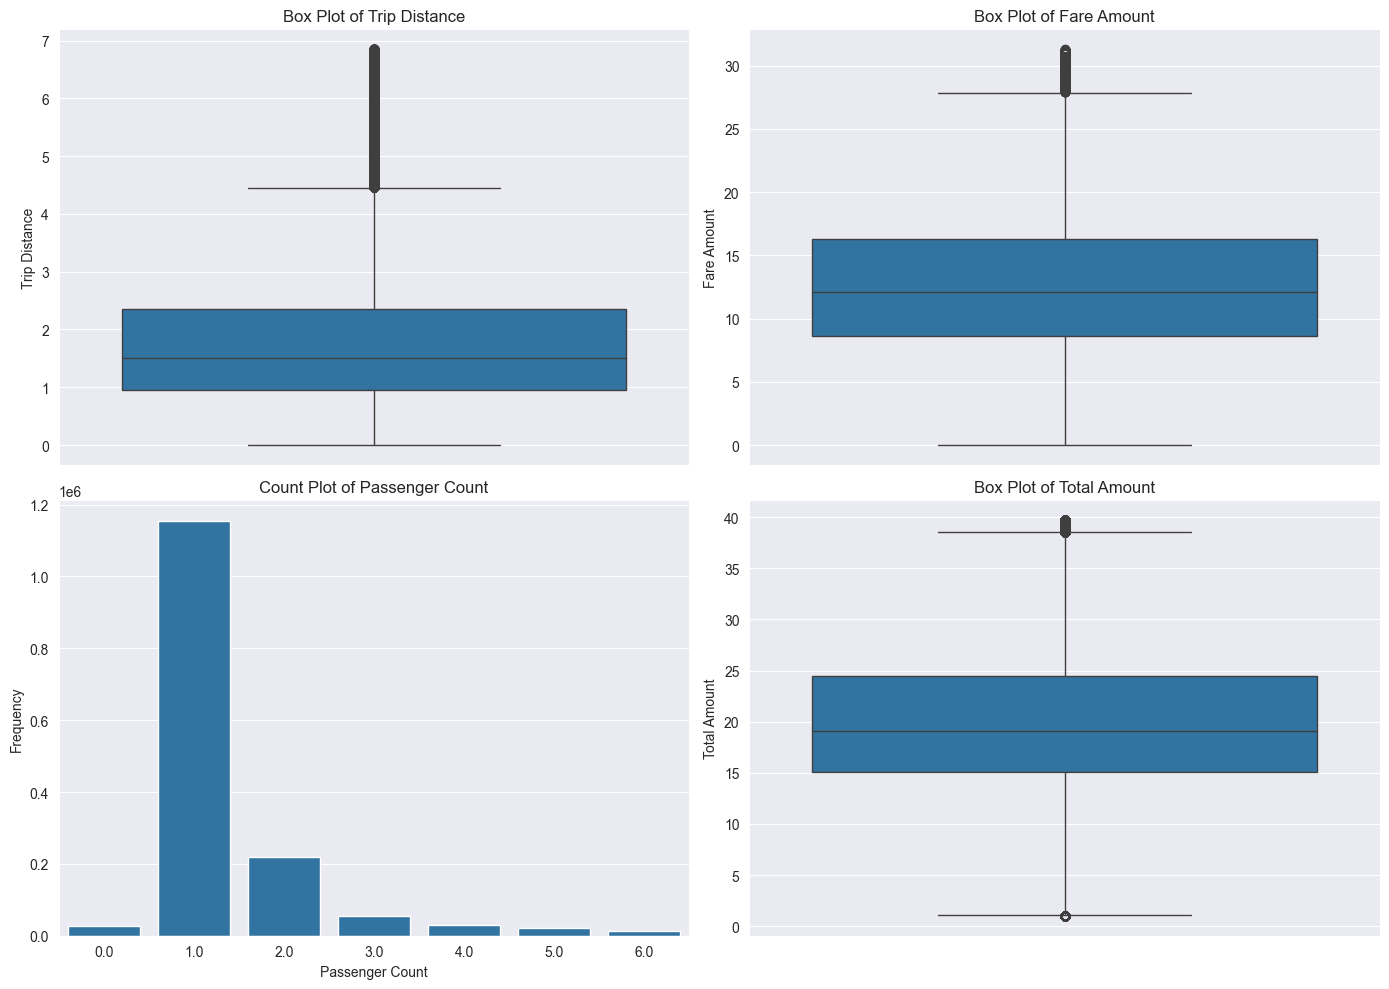

In [281]:
import matplotlib.pyplot as plt
import seaborn as sns

#... (your data loading and cleaning code)...

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns

# a. Trip Distance (top-left)
sns.boxplot(y=df['trip_distance'], ax=axes[0, 0])
axes[0, 0].set_title('Box Plot of Trip Distance')
axes[0, 0].set_ylabel('Trip Distance')

# b. Fare Amount (top-right)
sns.boxplot(y=df['fare_amount'], ax=axes[0, 1])
axes[0, 1].set_title('Box Plot of Fare Amount')
axes[0, 1].set_ylabel('Fare Amount')

# c. Passenger Count (bottom-left)
sns.countplot(x=df['passenger_count'], ax=axes[1, 0])
axes[1, 0].set_title('Count Plot of Passenger Count')
axes[1, 0].set_xlabel('Passenger Count')
axes[1, 0].set_ylabel('Frequency')

# d. Total Amount (bottom-right)
sns.boxplot(y=df['total_amount'], ax=axes[1, 1])
axes[1, 1].set_title('Box Plot of Total Amount')
axes[1, 1].set_ylabel('Total Amount')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# as we can see the outliers have been removed

In [282]:
df.to_csv("4_Cleaned_Outlier_Removed_Sampled_NYC_Taxi_Data.csv", index=False)
print("Cleaned data saved to '4_Cleaned_Outlier_Removed_Sampled_NYC_Taxi_Data.csv'")

Cleaned data saved to '4_Cleaned_Outlier_Removed_Sampled_NYC_Taxi_Data.csv'


In [283]:
num_rows = len(df)
print(f"Number of remaining rows: {num_rows}")

Number of remaining rows: 1518760


How will you fix each of these values? Which ones will you drop and which ones will you replace?

In [284]:
print('''
When dealing with outliers, there's no one-size-fits-all solution. The best approach depends on the nature of your data, the reason for the outliers (errors, natural variation, etc.),

Understanding the Outliers:
    Visual Inspection
    Domain Knowledge
    Investigate the Cause

Handling Outliers:
    1. Drop: If an outlier is due to an error or data entry mistake, it may be best to drop the entry.
    2. Replace: If an outlier is valid but extreme, it may be replaced with a more reasonable value.
    3. Keep: If an outlier is valid and expected, it may be kept as is.

How to do it:
    • Identify outliers using visual inspection, IQR, Z-score, or domain knowledge.
    • Use boolean indexing or the .drop() method in Pandas to remove the rows containing the outliers.

Imputation (Replacing with another value):
    • Mean, Median, Mode: Replacing with the mean, median, or mode of the column.
    • Custom Value: Replacing with a custom value based on domain knowledge.
    • Interpolation: Replacing with a value based on the surrounding data points.

Transformation:
    • Log Transformation: Applying a log transformation to the data to reduce the impact of outliers.

Winsorizing/Clipping:
      Replacing extreme values with the nearest less extreme value.

Keep the Outliers (Sometimes!):
    • If the outliers are valid data points and part of the distribution, they may be kept.
''')



When dealing with outliers, there's no one-size-fits-all solution. The best approach depends on the nature of your data, the reason for the outliers (errors, natural variation, etc.),

Understanding the Outliers:
    Visual Inspection
    Domain Knowledge
    Investigate the Cause

Handling Outliers:
    1. Drop: If an outlier is due to an error or data entry mistake, it may be best to drop the entry.
    2. Replace: If an outlier is valid but extreme, it may be replaced with a more reasonable value.
    3. Keep: If an outlier is valid and expected, it may be kept as is.

How to do it:
    • Identify outliers using visual inspection, IQR, Z-score, or domain knowledge.
    • Use boolean indexing or the .drop() method in Pandas to remove the rows containing the outliers.

Imputation (Replacing with another value):
    • Mean, Median, Mode: Replacing with the mean, median, or mode of the column.
    • Custom Value: Replacing with a custom value based on domain knowledge.
    • Interpolat

In [285]:
# Do any columns need standardising?

print('''
When to Standardize:

1. Machine Learning Algorithms:
    Many machine learning algorithms (especially those based on distance calculations or gradient descent) benefit from standardization.
        Standardizing features can:
            Prevent features with larger scales from dominating the model.
            Improve numerical stability.
            Speed up convergence in some algorithms.

2. Comparing Features with Different Units:
        If you have features with different units or scales (e.g., trip_distance in miles and fare_amount in dollars),
        standardizing them can make them more comparable.

3. Data Visualization:
    In some cases, standardizing can make it easier to visualize data with different scales on the same plot.

Common Standardization Methods:
1. Z-score Standardization:
2. Min-Max Scaling:

based on this data : trip_distance and fare_amount and total_amount should be standardized as they have different units.
''')



When to Standardize:

1. Machine Learning Algorithms:
    Many machine learning algorithms (especially those based on distance calculations or gradient descent) benefit from standardization.
        Standardizing features can:
            Prevent features with larger scales from dominating the model.
            Improve numerical stability.
            Speed up convergence in some algorithms.

2. Comparing Features with Different Units:
        If you have features with different units or scales (e.g., trip_distance in miles and fare_amount in dollars),
        standardizing them can make them more comparable.

3. Data Visualization:
    In some cases, standardizing can make it easier to visualize data with different scales on the same plot.

Common Standardization Methods:
1. Z-score Standardization:
2. Min-Max Scaling:

based on this data : trip_distance and fare_amount and total_amount should be standardized as they have different units.



In [286]:
try:
    df = pd.read_csv('4_Cleaned_Outlier_Removed_Sampled_NYC_Taxi_Data.csv')
except FileNotFoundError:
    print("Error: '4_Cleaned_Outlier_Removed_Sampled_NYC_Taxi_Data.csv' DataFrame not found or saved file not found. Please make sure you have sampled and saved the data first.")

In [287]:
# Analyse the above parameters
columns_to_check = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']

for col in columns_to_check:
    num_zeros = (df[col] == 0).sum()
    num_negatives = (df[col] < 0).sum()
    print(f"\nColumn '{col}':")
    print(f"  - Number of zero values: {num_zeros}")
    print(f"  - Number of negative values: {num_negatives}")

'''
There is no negative values in the dataset before standardization.
'''


Column 'fare_amount':
  - Number of zero values: 191
  - Number of negative values: 0

Column 'tip_amount':
  - Number of zero values: 335368
  - Number of negative values: 0

Column 'total_amount':
  - Number of zero values: 0
  - Number of negative values: 0

Column 'trip_distance':
  - Number of zero values: 15541
  - Number of negative values: 0


'\nThere is no negative values in the dataset before standardization.\n'

In [288]:
from sklearn.preprocessing import StandardScaler
# Select the columns to standardize
cols_to_standardize = ['trip_distance', 'fare_amount', 'total_amount']  # Include relevant columns

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the selected columns
scaler.fit(df[cols_to_standardize])

# Transform the selected columns
df[cols_to_standardize] = scaler.transform(df[cols_to_standardize])


print("\nStandardized Data Description:")
df.describe() # You'll see that the selected columns now have mean=0 and std=1



Standardized Data Description:


,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,hour,airport_fee
count,1.518760e+06,1.518760e+06,1.518760e+06,1.518760e+06,1.518760e+06,1.518760e+06,1.518760e+06,1.518760e+06,1.518760e+06,1.518760e+06,1.518760e+06,1.518760e+06,1.518760e+06,1.518760e+06,1.518760e+06,1.518760e+06
mean,1.357037e+00,-2.799578e-16,1.329338e+00,1.690434e+02,1.673792e+02,1.206937e+00,-1.758064e-15,1.423394e+00,4.988971e-01,2.551628e+00,1.049111e-02,9.995332e-01,-7.570277e-16,2.402266e+00,1.429041e+01,1.507957e-02
std,8.895864e-01,1.000000e+00,5.609096e+00,6.499618e+01,6.823739e+01,4.674629e-01,1.000000e+00,1.470988e+00,2.402499e-02,1.891801e+00,2.740698e-01,1.920384e-02,1.000000e+00,4.845437e-01,5.765248e+00,1.567446e-01
min,0.000000e+00,-1.537186e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-2.244849e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.802633e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,-7.209280e-01,1.000000e+00,1.370000e+02,1.250000e+02,1.000000e+00,-7.651675e-01,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,-7.528868e-01,2.500000e+00,1.100000e+01,0.000000e+00
50%,1.000000e+00,-2.617827e-01,1.000000e+00,1.630000e+02,1.630000e+02,1.000000e+00,-1.629718e-01,1.000000e+00,5.000000e-01,2.640000e+00,0.000000e+00,1.000000e+00,-1.751255e-01,2.500000e+00,1.500000e+01,0.000000e+00
75%,1.000000e+00,4.694487e-01,1.000000e+00,2.340000e+02,2.360000e+02,1.000000e+00,5.596631e-01,2.500000e+00,5.000000e-01,3.780000e+00,0.000000e+00,1.000000e+00,6.087717e-01,2.500000e+00,1.900000e+01,0.000000e+00
max,6.000000e+00,4.287157e+00,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,3.140502e+00,1.025000e+01,4.000000e+00,3.300000e+01,2.735000e+01,1.000000e+00,2.818201e+00,2.500000e+00,2.300000e+01,1.750000e+00


In [289]:
df.to_csv("Standard_Sampled_NYC_Taxi_Data.csv", index=False)
print("Standardized data saved to 'Standard_Sampled_NYC_Taxi_Data.csv'")

Standardized data saved to 'Standard_Sampled_NYC_Taxi_Data.csv'


## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [290]:
df.columns.tolist()

['tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'date',
 'hour',
 'airport_fee']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

In [291]:
print('''
Categorical Variables:

• VendorID
• RatecodeID
• PULocationID
• DOLocationID
• payment_type
• pickup_hour

Numerical Variables:
• tpep_pickup_datetime
• tpep_dropoff_datetime
• passenger_count
• trip_distance
• trip_duration

Dates and Times: Dates and times can sometimes be treated as both numerical and categorical, depending on the analysis. For example, you might use the numerical values of dates to calculate durations or time intervals, or you might treat dates as categories to analyze trends over time.

• fare_amount
• extra
• mta_tax
• tip_amount
• tolls_amount
• improvement_surcharge
• total_amount
• congestion_surcharge
• airport_fee
        These monetary parameters are all numerical variables. They represent amounts of money and can be treated as continuous numerical data.
''')


Categorical Variables:

• VendorID
• RatecodeID
• PULocationID
• DOLocationID
• payment_type
• pickup_hour

Numerical Variables:
• tpep_pickup_datetime
• tpep_dropoff_datetime
• passenger_count
• trip_distance
• trip_duration

Dates and Times: Dates and times can sometimes be treated as both numerical and categorical, depending on the analysis. For example, you might use the numerical values of dates to calculate durations or time intervals, or you might treat dates as categories to analyze trends over time.

• fare_amount
• extra
• mta_tax
• tip_amount
• tolls_amount
• improvement_surcharge
• total_amount
• congestion_surcharge
• airport_fee
        These monetary parameters are all numerical variables. They represent amounts of money and can be treated as continuous numerical data.



##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

In [292]:

try:
    df = pd.read_csv("Standard_Sampled_NYC_Taxi_Data.csv")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'Standard_Sampled_NYC_Taxi_Data.csv' not found. Please provide the correct file path.")
    exit()


Data loaded successfully.


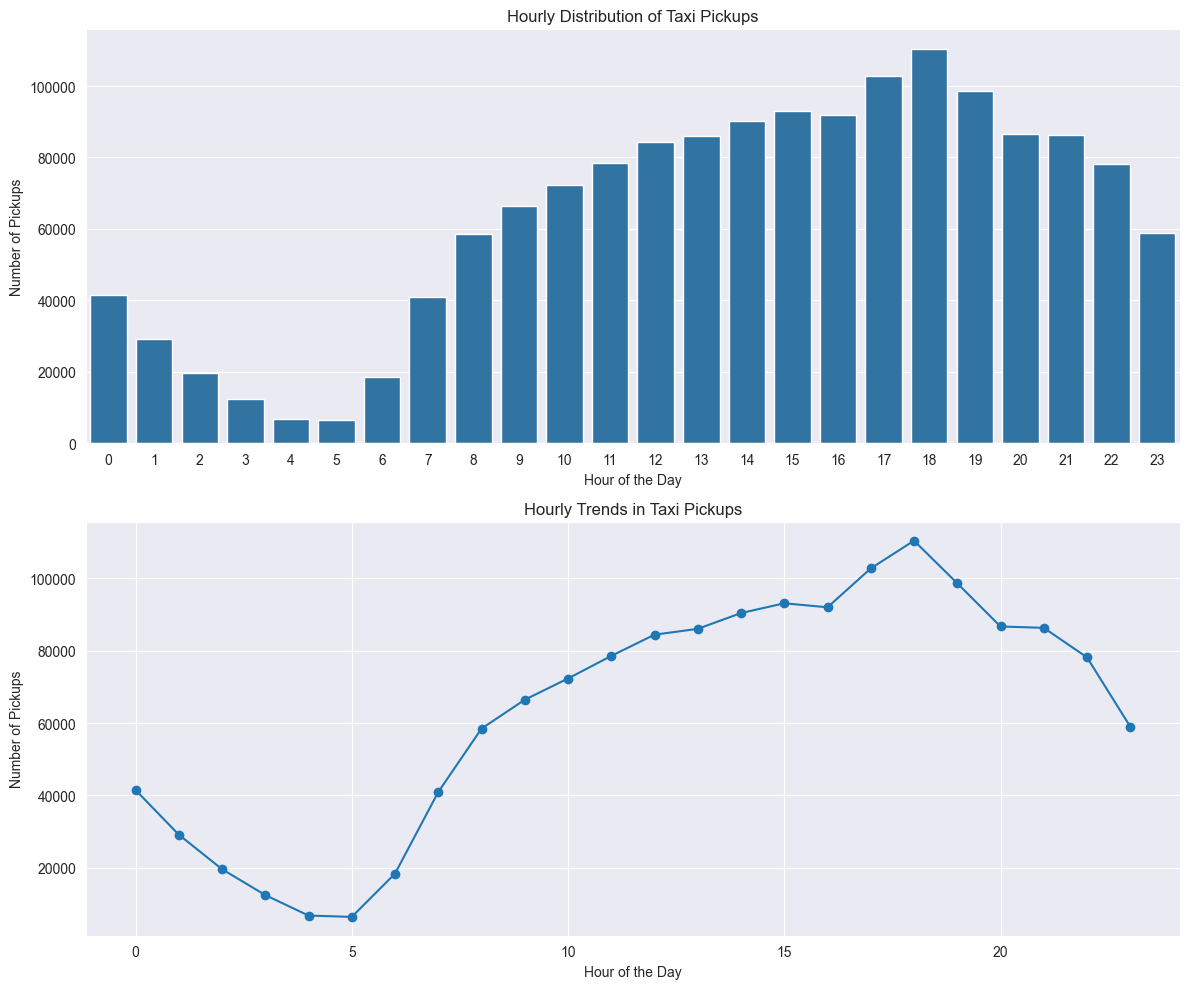

In [293]:
# Find and show the hourly trends in taxi pickups
'''
Hourly Trends: Identify peak hours when taxi demand is highest (e.g., rush hours, late nights).
'''

# 2. Convert pickup and dropoff datetime columns to datetime objects
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# 3. Extract hour, day of the week, and month from pickup datetime
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_dayofweek'] = df['tpep_pickup_datetime'].dt.dayofweek  # Monday=0, Sunday=6
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month

# a. Hourly Distribution
'''
Hourly Distribution: Calculates the number of pickups for each hour of the day using value_counts()
and plots a bar chart using sns.barplot().
'''
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `df` contains a column named 'pickup_hour' (integer 0-23)
# Group data to get hourly pickup counts
hourly_pickups = df['pickup_hour'].value_counts().sort_index()

# Group by pickup hour and count occurrences
hourly_trends = df.groupby('pickup_hour')['pickup_hour'].count()

# Create a 2-row, 1-column grid for subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# (a) Bar Plot: Hourly Distribution of Taxi Pickups
sns.barplot(x=hourly_pickups.index, y=hourly_pickups.values, ax=axes[0])
axes[0].set_title('Hourly Distribution of Taxi Pickups')
axes[0].set_xlabel('Hour of the Day')
axes[0].set_ylabel('Number of Pickups')

# (b) Line Plot: Hourly Trends
axes[1].plot(hourly_trends.index, hourly_trends.values, marker='o', linestyle='-')
axes[1].set_title('Hourly Trends in Taxi Pickups')
axes[1].set_xlabel('Hour of the Day')
axes[1].set_ylabel('Number of Pickups')
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plots
plt.show()


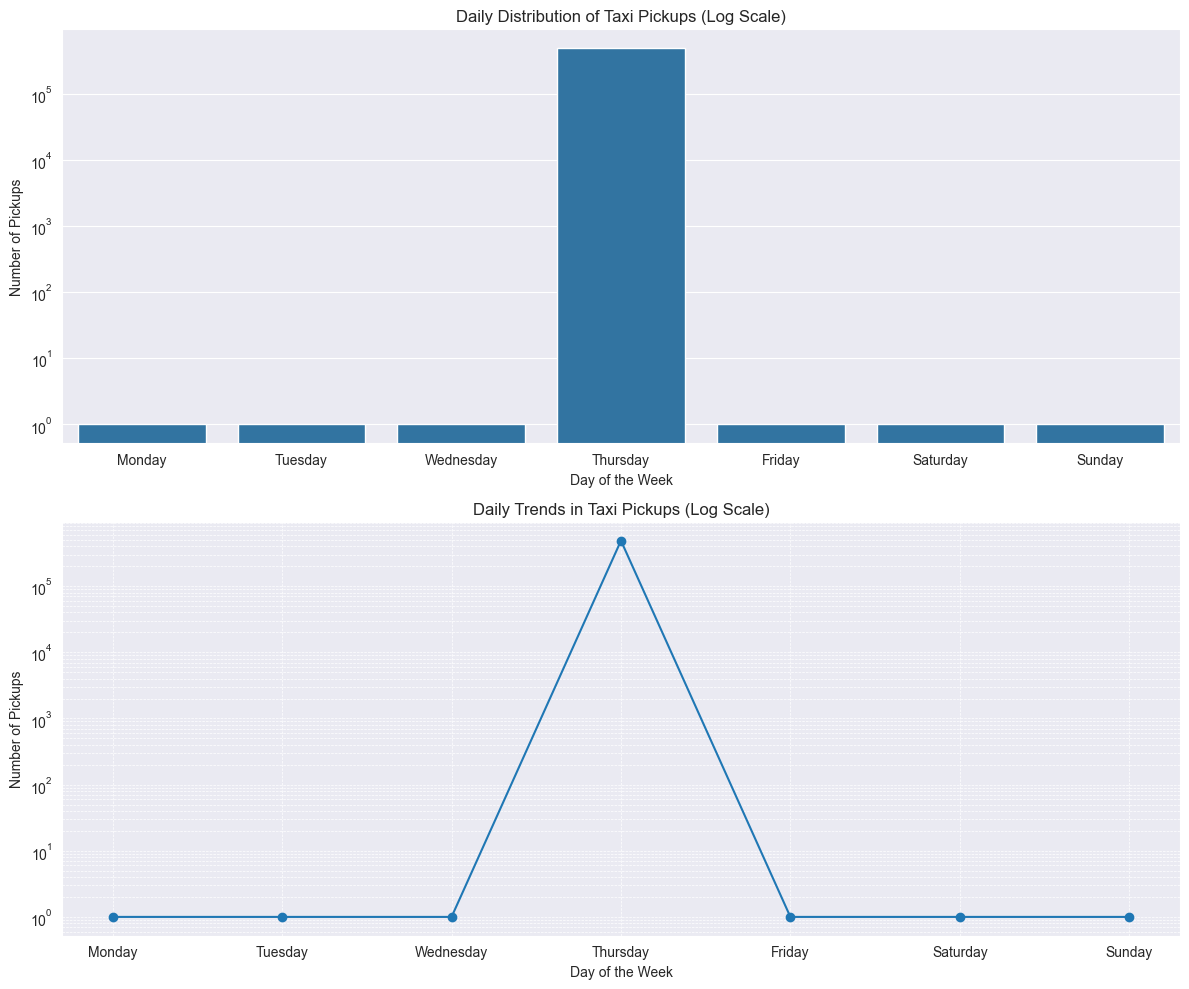

In [332]:
# Assuming `df` contains a column named 'pickup_dayofweek' (integer 0-6, where Monday=0 and Sunday=6)

# 2. Convert pickup and dropoff datetime columns to datetime objects
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# 3. Extract hour, day of the week, and month from pickup datetime
df['pickup_dayofweek'] = df['tpep_pickup_datetime'].dt.dayofweek  # Monday=0, Sunday=6


# Define day labels
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Count pickups per day of the week, ensuring all days (0-6) are present
daily_pickups = df['pickup_dayofweek'].value_counts().reindex(range(7), fill_value=1)  # Avoid log(0) issue

# Compute daily trends
daily_trends = df.groupby('pickup_dayofweek')['pickup_dayofweek'].count().reindex(range(7), fill_value=1)  # Avoid log(0) issue

# Create a 2-row, 1-column grid for subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# (a) Bar Plot: Daily Distribution of Taxi Pickups (Log Scale)
sns.barplot(x=day_labels, y=daily_pickups.values, ax=axes[0])
axes[0].set_title('Daily Distribution of Taxi Pickups (Log Scale)')
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Number of Pickups')
axes[0].set_yscale('log')  # Set y-axis to log scale

# (b) Line Plot: Daily Trends (Log Scale)
axes[1].plot(day_labels, daily_trends.values, marker='o', linestyle='-')
axes[1].set_title('Daily Trends in Taxi Pickups (Log Scale)')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Number of Pickups')
axes[1].set_yscale('log')  # Set y-axis to log scale
axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)  # Improve log-scale grid

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plots
plt.show()


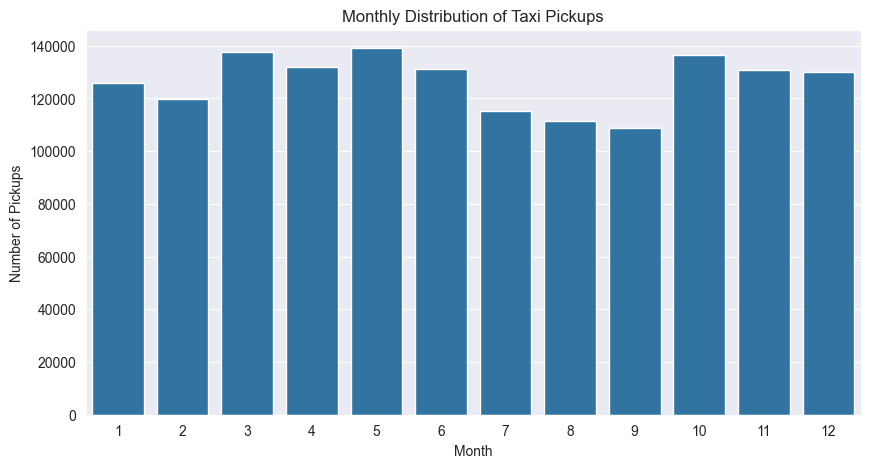

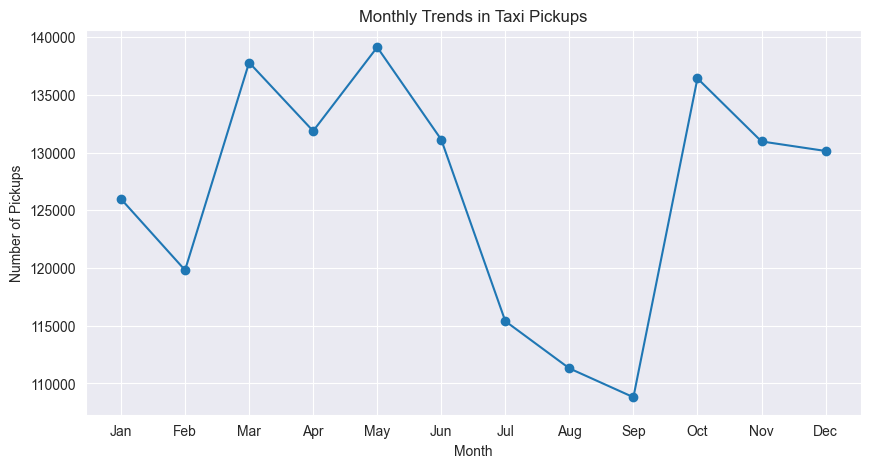

In [294]:
# Show the monthly trends in pickups
'''
Monthly Distribution: Counts the number of pickups for each month using value_counts() and plots a bar chart using sns.barplot().
'''
# c. Monthly Distribution
monthly_pickups = df['pickup_month'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_pickups.index, y=monthly_pickups.values)
plt.title('Monthly Distribution of Taxi Pickups')
plt.xlabel('Month')
plt.ylabel('Number of Pickups')
plt.show()

# Group by pickup month and count the number of pickups
monthly_trends = df.groupby('pickup_month')['pickup_month'].count()

# Create the line plot
plt.figure(figsize=(10, 5))
monthly_trends.plot(kind='line', marker='o')
plt.title('Monthly Trends in Taxi Pickups')
plt.xlabel('Month')
plt.ylabel('Number of Pickups')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])  # Set x-axis labels
plt.grid(True)
plt.show()


##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [295]:
# Analyse the above parameters
columns_to_check = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']

for col in columns_to_check:
    num_zeros = (df[col] == 0).sum()
    num_negatives = (df[col] < 0).sum()
    print(f"\nColumn '{col}':")
    print(f"  - Number of zero values: {num_zeros}")
    print(f"  - Number of negative values: {num_negatives}")

print('''
The standardization process (using StandardScaler ) centers the data around a mean of 0 and
scales it to have a standard deviation of 1. This inherently introduces negative values, as any
values originally below the mean will become negative after standardization.

Therefore, seeing negative values after standardization is expected.
''')


Column 'fare_amount':
  - Number of zero values: 0
  - Number of negative values: 881972

Column 'tip_amount':
  - Number of zero values: 335368
  - Number of negative values: 0

Column 'total_amount':
  - Number of zero values: 0
  - Number of negative values: 866205

Column 'trip_distance':
  - Number of zero values: 0
  - Number of negative values: 924841

The standardization process (using StandardScaler ) centers the data around a mean of 0 and
scales it to have a standard deviation of 1. This inherently introduces negative values, as any
values originally below the mean will become negative after standardization.

Therefore, seeing negative values after standardization is expected.



Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [296]:
# Create a df with non zero entries for the selected parameters.
# Filter out zero values from specified columns

'''
 It makes sense that some trips might have zero distance  but non-zero fares or total amounts if the pickup and dropoff locations
 are within the same zone.

 In those cases, filtering out the rows with zero trip_distance could lead to loss of information, as those trips might still
 be valid and have valuable insights.

 code includes a condition to filter out zero values in trip_distance ONLY IF both fare_amount and total_amount are also zero.
 This ensures that trips with zero distance but non-zero fares are retained.
'''
columns_to_filter = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']

for col in columns_to_filter:
    # Count zero values before filtering
    num_zeros_before = (df[col] == 0).sum()

    # Filter out zero values ONLY IF fare_amount and total_amount are also zero
    if col == 'trip_distance':
        df = df[~((df[col] == 0) & (df['fare_amount'] == 0) & (df['total_amount'] == 0))]
    else:
        df = df[df[col] > 0]

    # Count zero values after filtering
    num_zeros_after = (df[col] == 0).sum()

    print(f"\nColumn '{col}':")
    print(f"  - Number of zero values before filtering: {num_zeros_before}")
    print(f"  - Number of zero values after filtering: {num_zeros_after}")

df.to_csv("Cleaned_Standard_Sampled_NYC_Taxi_Data.csv", index=False)
print("Cleaned data saved to 'Cleaned_Standard_Sampled_NYC_Taxi_Data.csv'")



Column 'fare_amount':
  - Number of zero values before filtering: 0
  - Number of zero values after filtering: 0

Column 'tip_amount':
  - Number of zero values before filtering: 135019
  - Number of zero values after filtering: 0

Column 'total_amount':
  - Number of zero values before filtering: 0
  - Number of zero values after filtering: 0

Column 'trip_distance':
  - Number of zero values before filtering: 0
  - Number of zero values after filtering: 0
Cleaned data saved to 'Cleaned_Standard_Sampled_NYC_Taxi_Data.csv.csv'


In [306]:
try:
    df = pd.read_csv("Cleaned_Standard_Sampled_NYC_Taxi_Data.csv")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'Cleaned_Standard_Sampled_NYC_Taxi_Data.csv' not found. Please provide the correct file path.")
    exit()


Data loaded successfully.


**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend


Monthly Revenue:
pickup_month
1     37904.172251
2     37595.266599
3     44993.288456
4     43732.858820
5     49650.150059
6     46031.535554
7     37671.098187
8     36019.789856
9     40547.092788
10    51713.515704
11    48675.950752
12    47964.204578
Name: total_amount, dtype: float64


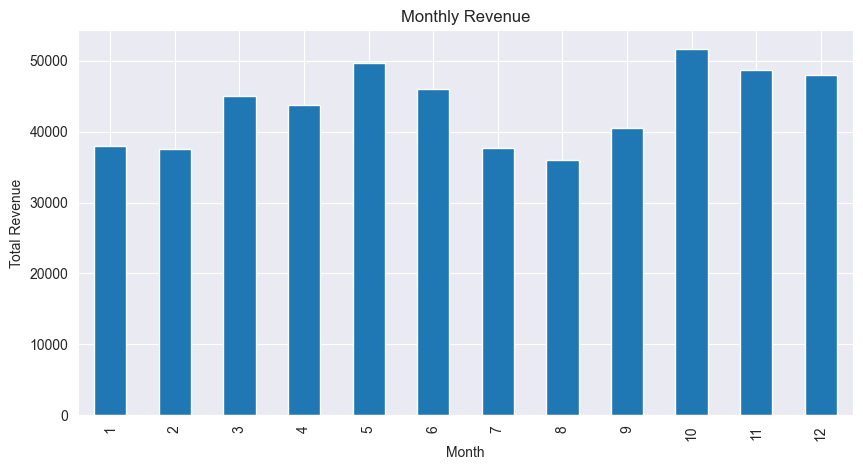

In [307]:
# Group data by month and analyse monthly revenue

# Convert pickup datetime to datetime object
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# Extract month from pickup datetime
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month

# Group by month and calculate total revenue
monthly_revenue = df.groupby('pickup_month')['total_amount'].sum()

# Print the monthly revenue
print("\nMonthly Revenue:")
print(monthly_revenue)

# (Optional) Plot the monthly revenue
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
monthly_revenue.plot(kind='bar')
plt.title('Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.show()


**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue


Proportion of Revenue for Each Quarter:
pickup_quarter
1    0.230609
2    0.266823
3    0.218638
4    0.283931
Name: total_amount, dtype: float64


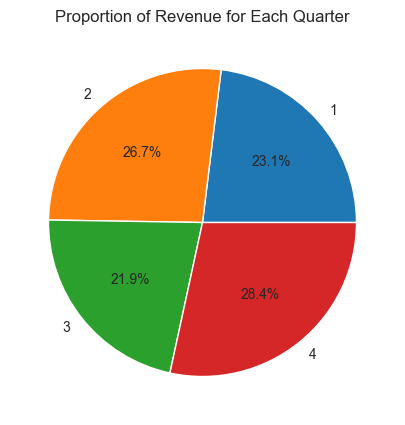

In [308]:
# Calculate proportion of each quarter

# Convert pickup datetime to datetime object
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# Extract quarter from pickup datetime
df['pickup_quarter'] = df['tpep_pickup_datetime'].dt.quarter

# Group by quarter and calculate total revenue
quarterly_revenue = df.groupby('pickup_quarter')['total_amount'].sum()

# Calculate proportion of revenue for each quarter
total_revenue = quarterly_revenue.sum()
quarter_proportions = quarterly_revenue / total_revenue

# Print the quarter proportions
print("\nProportion of Revenue for Each Quarter:")
print(quarter_proportions)

# (Optional) Plot the quarter proportions
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
quarter_proportions.plot(kind='pie', autopct='%1.1f%%')
plt.title('Proportion of Revenue for Each Quarter')
plt.ylabel('')  # Remove the default ylabel
plt.show()


**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

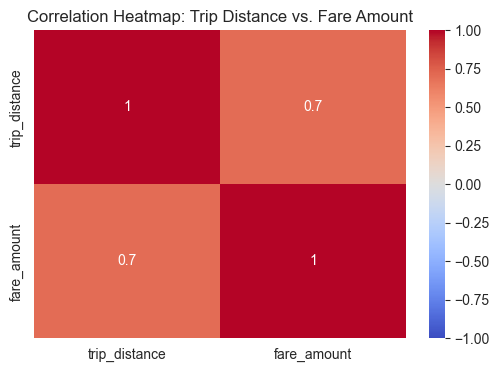


Correlation between trip_distance and fare_amount: 0.70


In [313]:
# Show how trip fare is affected by distance

df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime']).astype(int) / 10**9
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime']).astype(int) / 10**9

# 7. Create a heatmap to visualize the relationship between trip_distance and fare_amount

# Calculate the correlation matrix
corr_matrix = df[['trip_distance', 'fare_amount']].corr()

# Create the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Trip Distance vs. Fare Amount')
plt.show()

# Correlation value (already calculated in the heatmap, but printing it again for clarity)
correlation = df['trip_distance'].corr(df['fare_amount'])
print(f"\nCorrelation between trip_distance and fare_amount: {correlation:.2f}")

**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

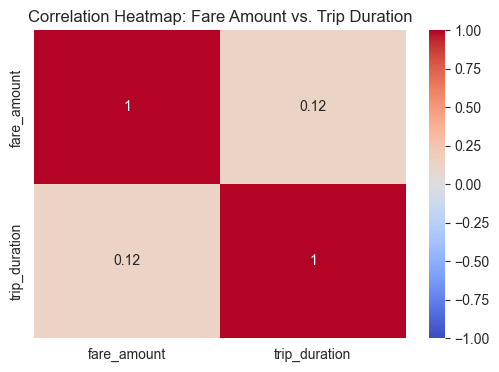


Correlation between fare_amount and trip_duration: 0.12


In [317]:
# Show relationship between fare and trip duration

# Calculate trip duration
df['trip_duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']

# Visualize relationship between fare_amount and trip_duration using heatmap and correlation

# Calculate the correlation matrix
corr_matrix = df[['fare_amount', 'trip_duration']].corr()

# Create the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Fare Amount vs. Trip Duration')
plt.show()

# Correlation value (already calculated in the heatmap, but printing it again for clarity)
correlation = df['fare_amount'].corr(df['trip_duration'])
print(f"\nCorrelation between fare_amount and trip_duration: {correlation:.2f}")

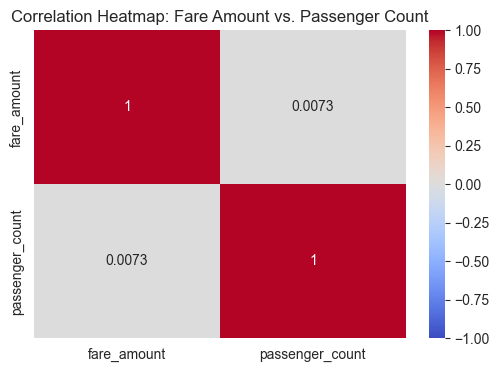


Correlation between fare_amount and passenger_count: 0.01


In [318]:
# Show relationship between fare and number of passengers
# Calculate the correlation matrix
corr_matrix = df[['fare_amount', 'passenger_count']].corr()

# Create the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Fare Amount vs. Passenger Count')
plt.show()

# Correlation value (already calculated in the heatmap, but printing it again for clarity)
correlation = df['fare_amount'].corr(df['passenger_count'])
print(f"\nCorrelation between fare_amount and passenger_count: {correlation:.2f}")


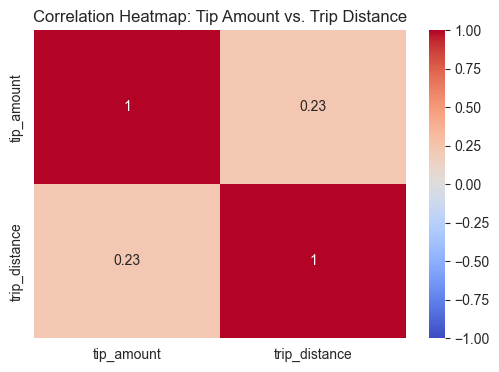


Correlation between tip_amount and trip_distance: 0.23


In [319]:
# Show relationship between tip and trip distance

# Calculate the correlation matrix
corr_matrix = df[['tip_amount', 'trip_distance']].corr()

# Create the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Tip Amount vs. Trip Distance')
plt.show()

# Correlation value (already calculated in the heatmap, but printing it again for clarity)
correlation = df['tip_amount'].corr(df['trip_distance'])
print(f"\nCorrelation between tip_amount and trip_distance: {correlation:.2f}")

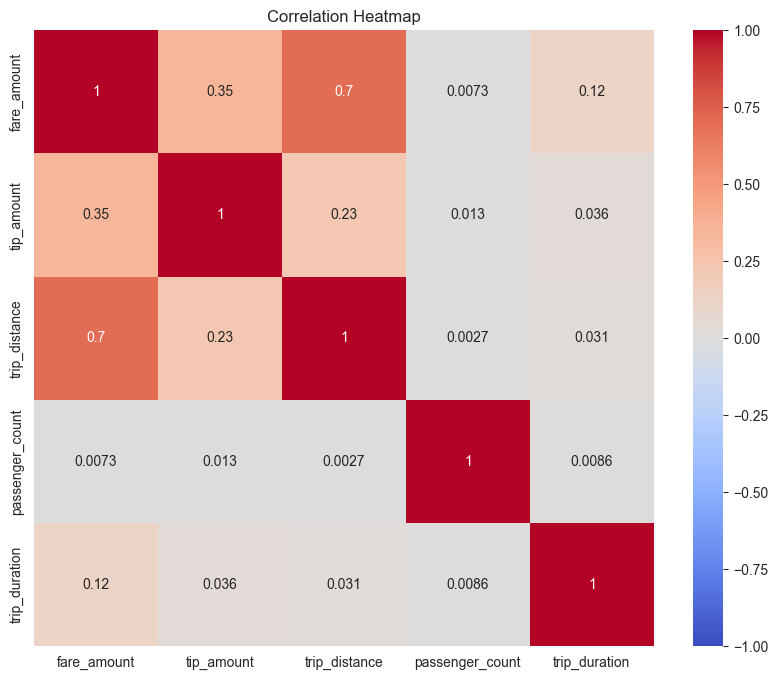

In [320]:
columns_for_correlation = ['fare_amount', 'tip_amount', 'trip_distance', 'passenger_count', 'trip_duration']

# Calculate the correlation matrix
corr_matrix = df[columns_for_correlation].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

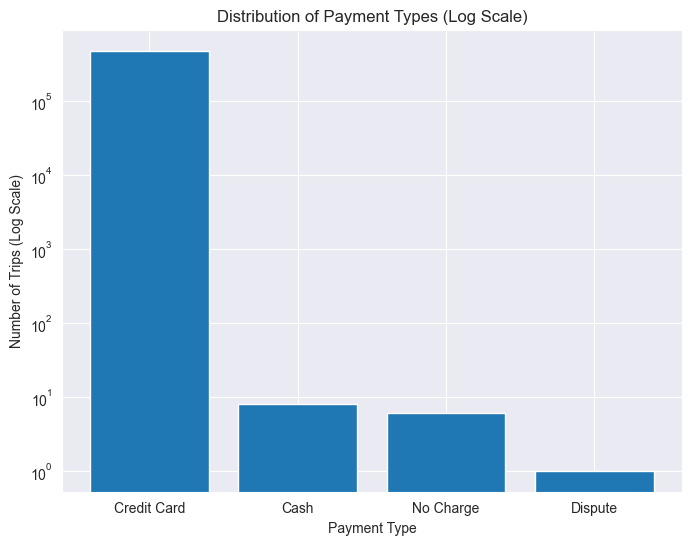


Payment Type Counts:
payment_type
1    486402
2         8
4         6
3         1
Name: count, dtype: int64

Payment Type Proportions:
Credit Card: 100.00%
Cash: 0.00%
Dispute: 0.00%
No Charge: 0.00%


In [323]:
# Analyse the distribution of different payment types (payment_type).

# Count the occurrences of each payment type
payment_type_counts = df['payment_type'].value_counts()

# Define the labels for the payment types
payment_type_labels = {
    1: 'Credit Card',
    2: 'Cash',
    3: 'No Charge',
    4: 'Dispute'
}

# Create a bar chart of the payment type distribution with log scale
plt.figure(figsize=(8, 6))
plt.bar(payment_type_labels.values(), payment_type_counts.values)
plt.title('Distribution of Payment Types (Log Scale)')
plt.xlabel('Payment Type')
plt.ylabel('Number of Trips (Log Scale)')
plt.yscale('log')  # Set y-axis to log scale
plt.show()

# Print the payment type counts and proportions
total_trips = payment_type_counts.sum()
print("\nPayment Type Counts:")
print(payment_type_counts)
print("\nPayment Type Proportions:")
for payment_type, count in payment_type_counts.items():
    proportion = count / total_trips
    print(f"{payment_type_labels.get(payment_type, 'Unknown')}: {proportion:.2%}")

- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [304]:
# !pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [305]:
# import geopandas as gpd


# Read the shapefile using geopandas
zones = # read the .shp file using gpd
zones.head()

SyntaxError: invalid syntax (4208933328.py, line 5)

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

In [ ]:
# print(zones.info())
# zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [ ]:
# Merge zones and trip records using locationID and PULocationID



**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [ ]:
# Group data by location and calculate the number of trips



**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [ ]:
# Merge trip counts back to the zones GeoDataFrame




The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

In [ ]:
# Define figure and axis


# Plot the map and display it



In [ ]:
# can you try displaying the zones DF sorted by the number of trips?



Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [ ]:
# Find routes which have the slowest speeds at different times of the day



How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

In [ ]:
# Visualise the number of trips per hour and find the busiest hour



Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [ ]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers
sample_fraction =



**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

In [ ]:
# Compare traffic trends for the week days and weekends



What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [ ]:
# Find top 10 pickup and dropoff zones



**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [ ]:
# Find the top 10 and bottom 10 pickup/dropoff ratios



**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [ ]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones



Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [ ]:
# Filter for night hours (11 PM to 5 AM)



##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [ ]:
# Analyse the fare per mile per passenger for different passenger counts




**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

In [ ]:
# Compare the average fare per mile for different days and for different times of the day



**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

In [ ]:
# Compare fare per mile for different vendors



**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


In [ ]:
# Defining distance tiers



##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

In [ ]:
#  Analyze tip percentages based on distances, passenger counts and pickup times



Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

In [ ]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%



**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

In [ ]:
# See how passenger count varies across hours and days




**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

In [ ]:
# How does passenger count vary across zones



In [ ]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.



Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [ ]:
# How often is each surcharge applied?



## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.